In [ ]:
import gc
import os
import logging
import math
import warnings
import re
import random
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

%matplotlib widget
from torch.amp import autocast, GradScaler
import time

# Suppress warnings
warnings.filterwarnings("ignore")

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def interrupt_execution():
    raise KeyboardInterrupt

def add_milliseconds_to_timestamp(df, timestamp_column, milliseconds_column, new_column_name):
    """
    Adds milliseconds to a timestamp column in a Pandas DataFrame.

    Args:
        df: The Pandas DataFrame.
        timestamp_column: The name of the column containing timestamps (datetime objects).
        milliseconds_column: The name of the column containing milliseconds.
        new_column_name: The name of the new column to store the updated timestamps.
    """
    # Convert the timestamp column to datetime objects if they aren't already
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], errors='coerce')

    # Convert milliseconds to Timedelta objects
    df[new_column_name] = df[timestamp_column] + pd.to_timedelta(df[milliseconds_column], unit='s')

    return df


def pearson_correlation_loss(y_true, y_pred):
    x = y_true - torch.mean(y_true, dim=0)
    y = y_pred - torch.mean(y_pred, dim=0)
    numerator = torch.sum(x * y, dim=0)
    denominator = torch.sqrt(torch.sum(x ** 2, dim=0)) * torch.sqrt(torch.sum(y ** 2, dim=0))
    correlation = numerator / (denominator + 1e-8)
    return -torch.mean(correlation)

def split_feature_unit(feature):
    match = re.match(r"(.+?)\s*\((.+)\)", feature)
    if match:
        feature_name = match.group(1).strip()
        unit = "[" + match.group(2).strip().replace("micro", "\u03BC") + "]"

    else:
        feature_name = feature.strip()
        unit = None  # No unit found
    
    return feature_name, unit

def randomSubjectEvaluation(autoencoder, optimizer='Adam', filename='autoencoder', ID='Random'):
    """
    Evaluate a random subject using a PyTorch autoencoder and plot the reconstruction results.

    Args:
        autoencoder (torch.nn.Module): The trained PyTorch autoencoder model.
        optimizer (str): Name of the optimizer used (for display purposes).
        filename (str): Filename for saving the reconstruction plots.
        ID (str): Subject ID to evaluate. Use 'Random' to select a random subject.
    """
    global data_tot, vars_to_use, rolling_window_size, scaler, scaler_data, resample, timestamps_df, data_tot, timestamps_df

    data = data_tot 

    i = 0
    print("Optimizer:", optimizer)

    while True:
        i += 1
        if i == 10:
            return

        # Select a random subject or a specific subject ID
        if ID == 'Random':
            random_subject_id = random.choice(list(data.keys()))
        else:
            random_subject_id = ID

        random_subject_data = data[random_subject_id]

        # Resample the data if needed
        if resample > 0:
            random_subject_data = random_subject_data.resample(f"{resample}s", on='timestamp').mean(numeric_only=True).reset_index()

        t = random_subject_data['timestamp']

        # Apply rolling window smoothing
        if rolling_window_size > 1:
            random_subject_data = random_subject_data.rolling(window=rolling_window_size, min_periods=1).mean(numeric_only=True)

        # Select the variables to use
        random_subject_data = random_subject_data[vars_to_use]

        # Scale the data
        scaler = scaler
        random_subject_data = pd.DataFrame(scaler.transform(random_subject_data), columns=vars_to_use)

        try:
            # Convert data to PyTorch tensor
            data_tensor = torch.tensor(random_subject_data.values, dtype=torch.float32).to(device)

            # Set the autoencoder to evaluation mode
            autoencoder.eval()

            # Perform reconstruction
            with torch.no_grad():
                reconstructed_tensor = autoencoder(data_tensor)

            # Convert reconstructed data back to a DataFrame
            predicted_data = pd.DataFrame(reconstructed_tensor.cpu().numpy(), columns=vars_to_use)
            break  # Exit the loop if reconstruction is successful

        except Exception as e:
            if ID == 'Random':
                print(f"Prediction failed for subject ID: {random_subject_id}. Retrying with a new subject ID.")
                continue
            else:
                print(f"Prediction failed for subject ID: {random_subject_id}. Retry with a new subject ID.")
                return

    # Calculate correlation and reconstruction error
    corr = {}
    reconstruction_error = {}
    for feature in vars_to_use:
        reconstruction_error[feature] = mean_absolute_error(random_subject_data[feature], predicted_data[feature])
        corr[feature] = stats.pearsonr(random_subject_data[feature], predicted_data[feature])[0]

    # Inverse transform the data if needed
    predicted_data = pd.DataFrame(scaler_data.inverse_transform(predicted_data), columns=vars_to_use)
    random_subject_data = pd.DataFrame(scaler_data.inverse_transform(random_subject_data), columns=vars_to_use)

    # Plot the real vs predicted data for each variable
    num_features = len(vars_to_use)
    fig, axes = plt.subplots(num_features, 1, figsize=(12, 2 * num_features), sharex=True)

    for i, feature in enumerate(vars_to_use):
        real_data = random_subject_data[feature].values
        predicted_data_feature = predicted_data[feature].values
        feature_name, unit = split_feature_unit(feature)

        # Ensure valid data for plotting
        real_data = np.nan_to_num(real_data, nan=0.0, posinf=0.0, neginf=0.0)
        predicted_data_feature = np.nan_to_num(predicted_data_feature, nan=0.0, posinf=0.0, neginf=0.0)

        # Scale predicted data to match real data's mean and variance
        predicted_data_feature = zscore(predicted_data_feature) * np.std(real_data) + np.mean(real_data)

        axes[i].plot(t, real_data, label='Actual Data', color='blue', alpha=0.7)
        axes[i].plot(t, predicted_data_feature, label='Reconstructed Data', color='red', alpha=0.7)
        axes[i].set_xlabel('Time')
        
        
        xlabels = timestamps_df.columns
        axes[i].set_xticklabels(xlabels, rotation=30, rotation_mode='anchor', ha='right')

        axes[i].set_title(f'{feature_name} - Correlation: {corr[feature]:.2f}')
        axes[i].set_ylabel(unit)
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axes[i].grid(True)

    fig.subplots_adjust(hspace=0.6)
    
    correlation_values = np.array(list(corr.values()), dtype=np.float32)
    reconstruction_error = pd.DataFrame(reconstruction_error, index=pd.Index([random_subject_id]), columns=vars_to_use)
    mean_correlation = np.mean(correlation_values)
    fig.suptitle(f'Actual vs Reconstructed Data, Subject ID: {random_subject_id}', fontsize=16)
    print(f"Subject ID: {random_subject_id}")
    print(f'\n{"Mean correlation:":<32}:  {mean_correlation:.2f}')
    fig.tight_layout()
    plt.show()

    return reconstruction_error, corr


# Function to output memory usage
def memory_usage():
    import psutil
    # Print the memory usage in MB
    mem = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
    return mem


def cleanup(keep_vars=None):
    """
    Clears unnecessary variables, models, and GPU memory to free resources.
    Keeps only the specified variables in the global namespace.

    Args:
        keep_vars (list): List of variable names to keep in the global namespace. All other variables will be deleted.
    """
    mem_before = memory_usage()

    if keep_vars is None:
        keep_vars = ['data_tot', 'timestamps_df', 'vars_to_use', 'df_tot', 'data_tot', 'df_tot', 'timestamps_df']

    # ✅ Delete all global DataFrames except the ones in keep_vars
    globals_to_delete = [var for var, val in globals().items() if isinstance(val, pd.DataFrame) and var not in keep_vars]

    for var in globals_to_delete:
        globals()[var] = None  # Help garbage collector
        del globals()[var]      # Delete variable

    # ✅ Delete PyTorch models and tensors
    model_vars = ['autoencoder', 'encoder', 'decoder', 'model', 'generator']
    for var in model_vars:
        if var in globals():
            globals()[var] = None  # Help garbage collection
            del globals()[var]      # Delete model

    # ✅ Release GPU memory (if applicable)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear cached memory
        torch.cuda.synchronize()  # Synchronize GPU operations

    # ✅ Force garbage collection
    gc.collect()

    mem_after = memory_usage()
    print(f"Memory usage after cleanup: {mem_after:.2f} MB (freed up {mem_before - mem_after:.2f} MB)")


Using device: cpu


In [2]:
# IMPORT THE TRAINING DATASET

import os
import pandas as pd
import numpy as np
from scipy.stats import zscore
import glob

timestamps = {}
timestamps_df = pd.DataFrame(columns=np.array(range(10)).astype(str))
df_tot = pd.DataFrame()
data_tot = {}


# files = np.sort(os.listdir(os.getcwd(), "Parquet"))
files = np.sort(os.listdir(os.path.join(os.getcwd(), "parquet")))
ID = [file.split('.json')[0] for file in files if '.json' in file] + [file.split('.parquet')[0] for file in files if '.parquet' in file]



for [parquet_file, id] in zip(files, ID):
    parquet_file = os.path.join(os.getcwd(), "parquet", parquet_file)
    if os.path.exists(parquet_file):
        df = pd.read_parquet(parquet_file)
        print(f"Loaded {id} from .parquet")
    else:
        print(f"File {parquet_file} not found. Skipping.")
        continue
    
    df.columns = df.columns.str.lower()
    start = df['timestamp'].iloc[0]
    end = df['timestamp'].iloc[-1]
    interval_length = (end - start) / 10
    ts = [start + i * interval_length for i in range(10)]
    ts = pd.to_datetime([t.round('s') for t in ts])
    timestamps_df.loc[id] = ts
    df_tot = pd.concat([df_tot, df], ignore_index=True)
    data_tot[id] = df

# Convert timestamps to intervals
for idx, subject_id in enumerate(ID):
    subject_id_clean = subject_id.replace("pretrain", "").lstrip("0")
    phase_times = timestamps_df.iloc[idx].dropna().to_list()
    phase_intervals = [(phase_times[i], phase_times[i + 1]) for i in range(len(phase_times) - 1)]
    timestamps[subject_id_clean] = phase_intervals


Loaded VP02 from .parquet
Loaded VP03 from .parquet
Loaded VP05 from .parquet
Loaded VP06 from .parquet
Loaded VP08 from .parquet
Loaded VP09 from .parquet
Loaded VP11 from .parquet
Loaded VP12 from .parquet
Loaded VP14 from .parquet
Loaded VP15 from .parquet
Loaded VP17 from .parquet
Loaded VP18 from .parquet
Loaded VP20 from .parquet
Loaded VP23 from .parquet
Loaded VP24 from .parquet
Loaded VP26 from .parquet
Loaded VP27 from .parquet
Loaded VP29 from .parquet
Loaded VP30 from .parquet
Loaded VP32 from .parquet
Loaded VP33 from .parquet
Loaded VP35 from .parquet
Loaded VP36 from .parquet
Loaded VP38 from .parquet
Loaded VP39 from .parquet
Loaded VP41 from .parquet
Loaded VP42 from .parquet
Loaded VP44 from .parquet
Loaded VP45 from .parquet
Loaded VP47 from .parquet
Loaded VP48 from .parquet
Loaded VP50 from .parquet
Loaded VP51 from .parquet
Loaded VP53 from .parquet
Loaded VP54 from .parquet
Loaded VP56 from .parquet
Loaded VP57 from .parquet
Loaded VP59 from .parquet
Loaded VP61 

In [11]:
# DEFINE THE VARIABLES TO USE

to_rem = [col.lower() for col in[
    'unnamed: 0',
    'Phasic Skin Conductance (a.u.)',
    'Tonic Skin Conductance (a.u.)',
    # 'Skin Conductance (microS)',
    'Skin Conductance Phasic Driver (a.u.)',
    'ID', 
    'Recording Start', 
    'Time Since Start (s)', 
    'Beta Angle (rad)',
    'Low Frequency Power (s^2/Hz)', 
    'High Frequency Power (s^2/Hz)',
    'Respiratory Frequency (cycles/minute)',
    # 'Sympathovagal Balance (a.u.)'
    'Respiration (a.u.)'
]] # Convert all to_rem entries to lowercase for matching

vars = df_tot.columns
# Only drop columns that exist in vars
to_rem_existing = [col for col in to_rem if col in vars]
vars_to_use = vars.drop(to_rem_existing)
vars_to_use = vars_to_use.drop('timestamp')
# Define variables
vars_to_use = pd.Index(vars_to_use)

In [12]:
vars_to_use

Index(['skin conductance (micros)', 'heart rate (bpm)',
       'sympathovagal balance (a.u.)'],
      dtype='object')

In [13]:
# REMOVE VARIABLES THAT AREN'T RELEVANT AND CLEAN UP THE WORKSPACE
# 'Timestamp', 'Satellite Count', 'Latitude (°)', 'Longitude (°)', 'Altitude (m)', 'Time since start (s)'
# remove from data_tot the ids that are saved into id_to_rem
id_to_rem = []
for id in data_tot.keys():
    # if the number of columns in data_tot[id] is less than the lengh of vars, remove the id from the dictionary
    if len(data_tot[id].columns) < len(vars):
        id_to_rem.append(id)
        continue
    data_tot[id] = data_tot[id][vars]

    for var in to_rem:
        if var in data_tot[id].columns:
            data_tot[id] = data_tot[id].drop(columns=[var])
id_to_rem = []
for id in data_tot.keys():
    # if the number of columns in data_tot[id] is less than the lengh of vars, remove the id from the dictionary
    if len(data_tot[id].columns) < len(vars):
        id_to_rem.append(id)
        continue
    data_tot[id] = data_tot[id][vars]

    for var in to_rem:
        if var in data_tot[id].columns:
            data_tot[id] = data_tot[id].drop(columns=[var])   

for id in data_tot.keys():
    data_tot[id] = pd.DataFrame(data_tot[id], columns=np.setdiff1d(vars, to_rem))
    data_tot[id] = data_tot[id].dropna()

cleanup()

Memory usage after cleanup: 2643.78 MB (freed up -6.55 MB)


In [14]:
class SubjectDataset(Dataset):
    def __init__(self, subject_dict, rolling_window_size=15, vars_to_use=['All'], scaler=None, resample=0):
        """
        PyTorch Dataset for subject data.

        Args:
            subject_dict (dict): Dictionary where keys are subject IDs and values are DataFrames containing subject data.
            rolling_window_size (int): Size of the rolling window for smoothing the time series.
            vars_to_use (list): Variables to include in the dataset. Use ['All'] to include all variables.
            scaler (object): Scaler object (e.g., MinMaxScaler) to apply to the data. Use `None` for no scaling.
            resample (int): Resampling interval in seconds. Use 0 for no resampling.
        """
        self.data = []
        self.vars_to_use = vars_to_use
        self.rolling_window_size = rolling_window_size
        self.scaler = scaler
        self.resample = resample

        # Process each subject's data
        for subject_id, subject_data in subject_dict.items():
            if subject_data.shape[0] == 0:
                continue

            # Resample if needed
            if resample > 0:
                subject_data = subject_data.resample(f"{resample}s", on="timestamp").mean(numeric_only=True).reset_index()

            # Select variables to use
            if vars_to_use[0] != 'All':
                subject_data = subject_data[vars_to_use]

            # Smooth the time series with a rolling window
            subject_data = subject_data.rolling(window=rolling_window_size, min_periods=1).mean()

            # Apply scaling if a scaler is provided
            if scaler is not None:
                subject_data[vars_to_use] = scaler.transform(subject_data[vars_to_use])

            # Append the processed data
            self.data.append(subject_data.values)

        # Combine all data into a single array
        self.data = torch.tensor(np.concatenate(self.data), dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Autoencoders use input = output
        return self.data[idx], self.data[idx]

class SegmentDataset(Dataset):
    def __init__(self, subject_dict, phase_timestamps, rolling_window_size=15, vars_to_use=['All'], scaler=None, resample=0):
        """
        PyTorch Dataset for segmented data corresponding to specific phases.

        Args:
            subject_dict (dict): Dictionary where keys are subject IDs and values are DataFrames containing subject data.
            phase_timestamps (dict): Dictionary where keys are subject IDs and values are lists of tuples (start_time, end_time) for each phase.
            rolling_window_size (int): Size of the rolling window for smoothing the time series.
            vars_to_use (list): Variables to include in the dataset. Use ['All'] to include all variables.
            scaler (object): Scaler object (e.g., MinMaxScaler) to apply to the data. Use `None` for no scaling.
            resample (int): Resampling interval in seconds. Use 0 for no resampling.
        """
        self.data = []
        self.vars_to_use = vars_to_use
        self.rolling_window_size = rolling_window_size
        self.scaler = scaler
        self.resample = resample

        # Process each subject's data
        for subject_id, subject_data in subject_dict.items():
            if subject_data.shape[0] == 0:
                continue

            # Remove "Bicocca" prefix and leading zeros from subject ID
            subject_id = subject_id.replace("Bicocca", "").lstrip("0")

            # Skip if no phase timestamps are available for the subject
            subject_phases = phase_timestamps.get(subject_id, [])
            if not subject_phases:
                continue

            for phase_start, phase_end in subject_phases:
                # Extract the data corresponding to the phase
                phase_data = subject_data[(subject_data['timestamp'] >= phase_start) & (subject_data['timestamp'] <= phase_end)]
                if phase_data.empty:
                    continue

                # Resample if needed
                if resample > 0:
                    phase_data = phase_data.resample(f"{resample}s", on="timestamp").mean(numeric_only=True).reset_index()

                # Select variables to use
                if vars_to_use[0] != 'All':
                    phase_data = phase_data[vars_to_use]

                # Smooth the time series with a rolling window
                phase_data = phase_data.rolling(window=rolling_window_size, min_periods=1).mean()

                # Apply scaling if a scaler is provided
                if scaler is not None:
                    phase_data[vars_to_use] = scaler.transform(phase_data[vars_to_use])

                # Append the processed phase data
                self.data.append(phase_data.values)

        # Combine all data into a single array
        self.data = torch.tensor(np.concatenate(self.data), dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Autoencoders use input = output
        return self.data[idx], self.data[idx]

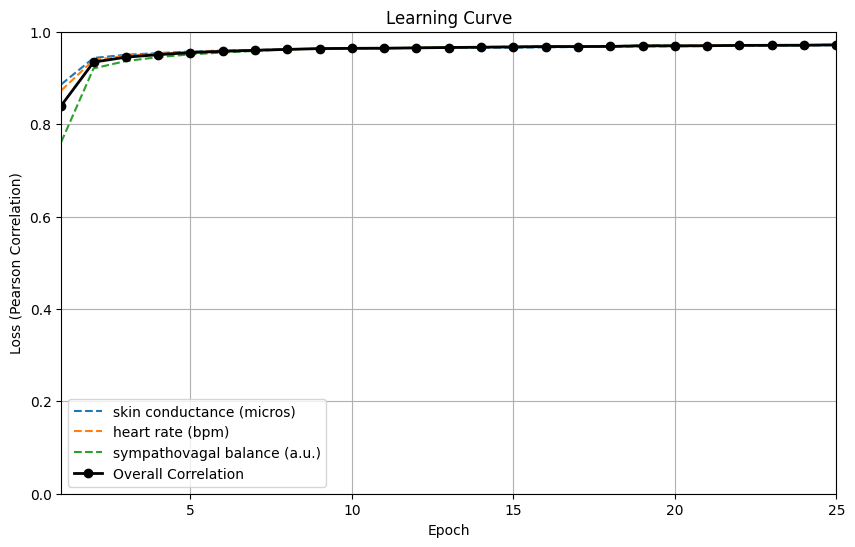

Epoch 25/25 | Loss: -0.9716 | Variable loss: ['0.9710', '0.9720', '0.9718'] | Time: 20.52s | ETA: 0.00s


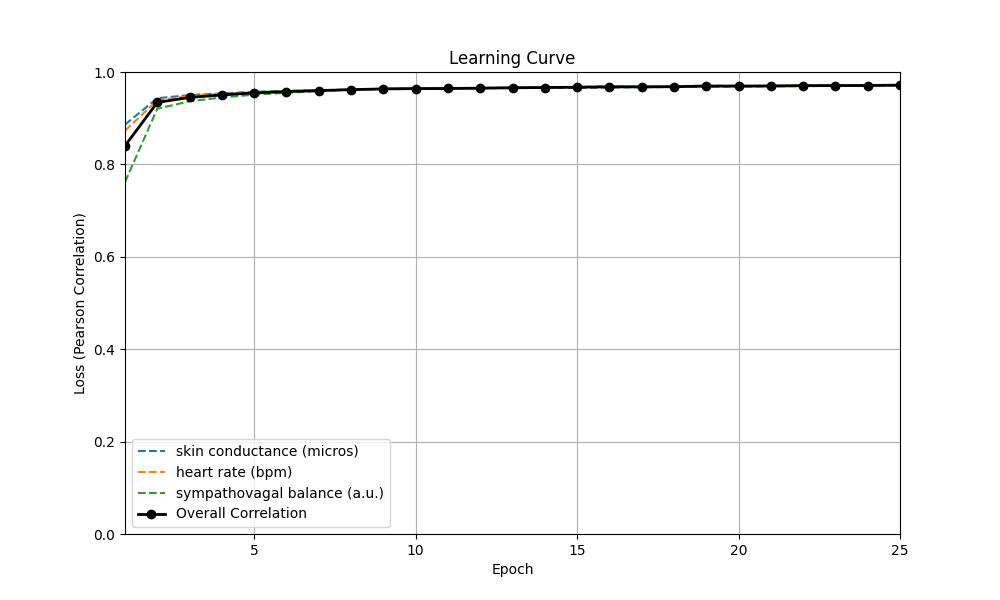

RuntimeError: Parent directory MODELS does not exist.

In [ ]:
# MODEL # 3 - AUTOENCODER WITH ATTENTION LAYER - SUBJECTS AS BATCHES


# Define the Autoencoder with Attention Layer
class AutoencoderWithAttention(nn.Module):
    def __init__(self, input_dim, neurons, attention=False, dropout_factor = 0.2, attention_heads = 4):
        
        super(AutoencoderWithAttention, self).__init__()
        self.attention = attention

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, neurons * 16),
            nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(neurons * 16, neurons * 8),
            nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(neurons * 8, neurons * 4),
            nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(neurons * 4, neurons),
            nn.ReLU(),
            nn.Dropout(dropout_factor)
        )

        # Attention Layer
        if attention:
            self.attention_layer = nn.MultiheadAttention(embed_dim=neurons, num_heads=attention_heads, batch_first=True)
            self.layer_norm = nn.LayerNorm(neurons)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(neurons, neurons),
            nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(neurons, neurons * 4),
            nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(neurons * 4, neurons * 8),
            nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(neurons * 8, neurons * 16),
            nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(neurons * 16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Attention (if enabled)
        if self.attention:
            x = x.unsqueeze(1)  # Add sequence length dimension
            attn_output, _ = self.attention_layer(x, x, x)
            x = x.squeeze(1)  # Remove sequence length dimension
            x = self.layer_norm(attn_output.squeeze(1) + x)

        # Decoder
        x = self.decoder(x)
        return x
    
def pearson_correlation_loss(y_true, y_pred):
    # Force computations to float32 for stability
    x = (y_true - torch.mean(y_true, dim=0)).float()
    y = (y_pred - torch.mean(y_pred, dim=0)).float()
    numerator = torch.sum(x * y, dim=0)
    denominator = torch.sqrt(torch.sum(x ** 2, dim=0)) * torch.sqrt(torch.sum(y ** 2, dim=0))
    correlation = numerator / (denominator + 1e-8)
    return -torch.mean(correlation), correlation

def train_autoencoder(autoencoder, dataloader, optimizer, criterion, epochs=50, device=torch.device("cuda")):
 
    global vars_to_use
    autoencoder.to(device)
    autoencoder.train()

    scaler = GradScaler("cuda")
    # GPU memory usage (in MB)
    allocated = torch.cuda.memory_allocated(device) / 1024**2
    reserved = torch.cuda.memory_reserved(device) / 1024**2

    print(f"GPU: Allocated {allocated:.2f} MB, Reserved {reserved:.2f} MB")

    losses = []  # Overall loss
    var_losses = [[] for _ in range(input_dim)]  # Loss per variable

    # Initialize the plot
    # initialize plot only once outside the training loop
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.clear()
    lines = [ax.plot([], [], linestyle='--', label=f'{vars_to_use[i]}')[0] for i in range(input_dim)]
    line, = ax.plot([], [], marker='o', label='Overall Correlation', color='black', linewidth=2)
    ax.set_xlim(1, max(2, epochs))
    ax.set_ylim(0, 1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (Pearson Correlation)')
    ax.set_title('Learning Curve')
    ax.grid(True)
    ax.legend()
    
    total_start_time = time.time()
    epoch_logs = []  # Store logs for saving later
    for epoch in range(epochs):

        epoch_corr = torch.zeros(input_dim, device=device)
        batch_count = 0
        epoch_loss = 0
        start_time = time.time()

        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)

            optimizer.zero_grad()

            with autocast(device_type=device.type):
                reconstructed = autoencoder(batch_x)
                loss, corr_vector = criterion(reconstructed, batch_x)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            epoch_corr += corr_vector.detach()
            batch_count += 1

        end_time = time.time()
        duration = end_time - start_time

        avg_loss = epoch_loss / batch_count
        avg_corr = epoch_corr / batch_count
        losses.append(abs(avg_loss))
        for i in range(input_dim):
            var_losses[i].append(abs(avg_corr[i].item()))

        # Update the plot
        line.set_data(range(1, len(losses) + 1), losses)
        for i in range(input_dim):
            lines[i].set_data(range(1, len(var_losses[i]) + 1), var_losses[i])
        ax.relim()
        ax.autoscale_view()
        from IPython.display import display, clear_output
        clear_output(wait=True)
        display(fig)

        elapsed_time = time.time() - total_start_time
        eta = (elapsed_time / (epoch + 1)) * (epochs - epoch - 1)
        epoch_log = f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Variable loss: {[f'{var_losses[i][-1]:.4f}' for i in range(input_dim)]} | Time: {duration:.2f}s | ETA: {eta:.2f}s"
        print(epoch_log)
        epoch_logs.append(epoch_log)

    # Finalize the plot
    plt.ioff()
    plt.savefig(get_unique_filename("training_loss_curve", "png"))
    enc_layers, dec_layers, enc_neurons, dec_neurons = count_model_layers_and_neurons(autoencoder)

    log_file_path = get_unique_filename("training_logs", "txt")
    with open(log_file_path, "w") as f:
        f.write("Model Specifications:\n")
        f.write(f"Encoder: {enc_layers} layers ({enc_neurons} neurons)\n")
        f.write(f"Decoder: {dec_layers} layers ({dec_neurons} neurons)\n")
        f.write(f"input_dim: {input_dim}\n")
        f.write(f"neurons: {neurons}\n")
        f.write(f"dropout_factor: {dropout_factor}\n")
        f.write(f"attention: {attention}\n")
        f.write(f"batch_size: {batch_size}\n")
        f.write(f"learning_rate: {learning_rate}\n")
        f.write(f"epochs: {epochs}\n")
        f.write(f"attention_heads: {attention_heads}\n")
        f.write(f"by_segment: {by_segment}\n")
        f.write("Epoch Logs:\n")
        f.write("\n".join(epoch_logs))
        
    plt.show()

# Helper function to count encoder/decoder layers
def count_model_layers_and_neurons(model):
    encoder_layers = sum(1 for layer in model.encoder if isinstance(layer, nn.Linear))
    decoder_layers = sum(1 for layer in model.decoder if isinstance(layer, nn.Linear))
    encoder_neurons = sum(layer.out_features for layer in model.encoder if isinstance(layer, nn.Linear))
    decoder_neurons = sum(layer.out_features for layer in model.decoder if isinstance(layer, nn.Linear))
    return encoder_layers, decoder_layers, encoder_neurons, decoder_neurons

# Helper function to generate unique filenames
def get_unique_filename(base_name, ext):
    i = 1
    while os.path.exists(f"{base_name}_{i}.{ext}"):
        i += 1
    return f"{base_name}_{i}.{ext}"

# Define parameters
input_dim = len(vars_to_use)
neurons = 8
dropout_factor = 0.1
attention = True
batch_size = 32
learning_rate = 0.0005
epochs = 25
attention_heads = 4
by_segment = True

# COMPUTE THE SCALER
rolling_window_size = 5
resample = 1

scaler_data = MinMaxScaler().fit(df_tot.resample(str(resample) + 's', on='timestamp').mean(numeric_only=True).reset_index()[vars_to_use].dropna().values)
scaler = MinMaxScaler().fit(df_tot.resample(str(resample) + 's', on='timestamp').mean(numeric_only=True).reset_index()[vars_to_use].dropna().values)

plt.close('all')
# Define the dataset and dataloader
if by_segment:
    dataset = SegmentDataset(
        subject_dict=data_tot,
        phase_timestamps=timestamps,
        rolling_window_size=rolling_window_size,
        vars_to_use=vars_to_use,
        scaler=scaler,
        resample=resample
    )
else:
    dataset = SubjectDataset(
        subject_dict=data_tot,
        rolling_window_size=rolling_window_size,
        vars_to_use=vars_to_use,
        scaler=scaler,
        resample=resample
    )

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the model
autoencoder = AutoencoderWithAttention(input_dim=input_dim, 
                                       neurons=neurons, 
                                       attention=attention, 
                                       dropout_factor=dropout_factor, 
                                       attention_heads=attention_heads)

# Define the optimizer and loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = pearson_correlation_loss  # Replace with your custom loss function

print("Training started... \n")
# Train the model
train_autoencoder(autoencoder, 
                  dataloader, 
                  optimizer, 
                  criterion, 
                  epochs=epochs, 
                  device=device)

# Save the model
os.makedirs("MODELS", exist_ok=True)

torch.save(autoencoder.state_dict(), f"MODELS/autoencoder_{'attention' if attention else 'no_attention'}.pth")

# Evaluate a random subject
randomSubjectEvaluation(autoencoder, 
                        optimizer='Adam', 
                        filename='autoencoder')


In [ ]:
## EVALUATE EACH SUBJECT: PLOT RECONSTRUCTION VS ORIGINAL DATA, COMPUTE CORRELATION AND MAE
# Import the PyTorch model and evaluate it on each subject
import torch
import pandas as pd
import gc



# Prepare data
data = df_tot.resample(str(resample) + 's', on='timestamp').mean(numeric_only=True).reset_index()[vars_to_use].dropna().values

# Initialize results DataFrames
ids = list(data_tot.keys())
subject_errors = pd.DataFrame(columns=vars_to_use)
pearson_correlations = pd.DataFrame(columns=vars_to_use)

# Evaluate the model on each subject
for ID in ids:
    # Evaluate the subject using the PyTorch model
    try:
        error, corr = randomSubjectEvaluation(
            autoencoder,
            optimizer='Adam',
            ID=ID
        )
        plt.pause(0.1)
    except:
        print(f"Error evaluating subject {ID}.")
        continue
    # Flatten `error` and `corr` if needed
    if isinstance(error, dict):
        error = {k: v[0] if isinstance(v, (list, np.ndarray)) else v for k, v in error.items()}
    if isinstance(corr, dict):
        corr = {k: v[0] if isinstance(v, (list, np.ndarray)) else v for k, v in corr.items()}

    # # Convert to DataFrame
    # error_df = pd.DataFrame(error, index=ID)
    corr = pd.DataFrame(corr, index=[ID])

    # Append results to DataFrames
    subject_errors = pd.concat([subject_errors, error])
    pearson_correlations = pd.concat([pearson_correlations, corr])

    # Perform garbage collection
    gc.collect()

# Results are stored in `subject_errors` and `pearson_correlations`